In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.api import Holt

#personal imports
from acquire import opene2e
from prepare import prepare, summarize

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#visual format
pd.options.display.float_format = '{:20,.2f}'.format

#plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Executive Summary
- Purpose: Analyze the patterns in temperature over time using earth surface temperature data.
- Goal: Model Springfield, US patterns forecasting temperature 36 months into the future.
- Key Takeaways: 
    - Earth surface temperature from 1963 - 2013 (50 years).
    - Average Springfield temperature between 1743 - 2013 is 52.5F.
    - Average Springfield temperature between 1963 - 2013 is 51.9F.
    - Highest and coldest recorded temperature 1743 - 2013 86.4F and 12F.
- Prediction and Forecast:
    - Tested on Previous Cycle
    - RMSE 8.0 (test) RMSE 6.0 (train)
    - Average temperature predicted 57.1F
    - Hottest temperature predicted 86.6F
    - Coldest temperature predicted 28.2F
- Bottom Line
    - Temperature is predicted to increase over time.

### Plan
- Acquire and prepare the earh surface temperature for Springfield, USA for analysis to provide future temperature predictions.
- Analysis will be done on a timeseries data pipeline.
- Data used can be found <a href="https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data">here</a>.
- Prediction is available for download in the conclusion section of this project.

## Acquire
- Acquired earth surface temperature data data from <a href="https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data">here</a>.
- Acquire function used to read in csv data.

In [2]:
df = opene2e()
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.07,1.74,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [3]:
summarize(df)

(8599212, 7)
___________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB
None
___________________________
dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64


##### Key Takeaways
- Shape (8.5M rows, 7 columns)
- Columns will be renamed for readability.
- Convert necessary data types (datetime, float).
- Large amount of missing temperature values.
- Reset index to timeseries.

## Prepare
- Prepare data for analysis.
- Decision making takeaways will be listed at the end of the Prepare section.

In [4]:
df = prepare(df)
df.head()

,avg_temp,avgtemp_uncertainty,city,country,latitude,longitude
date,,,,,,
1963-08-01,65.42,32.34,Springfield,United States,42.59,72.00
1963-08-01,72.98,32.94,Springfield,United States,39.38,89.48
1963-08-01,78.45,32.92,Springfield,United States,37.78,93.56
1963-09-01,56.28,32.31,Springfield,United States,42.59,72.00
1963-09-01,71.52,32.72,Springfield,United States,37.78,93.56


In [5]:
summarize(df)

(1803, 6)
___________________________
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1803 entries, 1963-08-01 to 2013-08-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   avg_temp             1803 non-null   float64
 1   avgtemp_uncertainty  1803 non-null   float64
 2   city                 1803 non-null   object 
 3   country              1803 non-null   object 
 4   latitude             1803 non-null   float64
 5   longitude            1803 non-null   float64
dtypes: float64(4), object(2)
memory usage: 98.6+ KB
None
___________________________
avg_temp               0
avgtemp_uncertainty    0
city                   0
country                0
latitude               0
longitude              0
dtype: int64


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_temp,"1,803.00",52.49,17.65,12.60,37.06,54.24,68.23,86.44
avgtemp_uncertainty,"1,803.00",32.50,0.16,32.11,32.38,32.48,32.60,33.07
latitude,"1,803.00",39.92,2.00,37.78,37.78,39.38,42.59,42.59
longitude,"1,803.00",85.01,9.35,72.00,72.00,89.48,93.56,93.56


In [7]:
print('Average, Max and Min temperature recorded:', df.avg_temp.mean(), df.avg_temp.max(), 'and', df.avg_temp.min(), 'respectively')

Average, Max and Min temperature recorded: 52.48606356073204 86.4392 and 12.603200000000001 respectively


In [8]:
print('Date Range:', df.index.min(), 'to', df.index.max())

Date Range: 1963-08-01 00:00:00 to 2013-08-01 00:00:00


In [9]:
#Going to drop all but the index, avg temp and uncertainty here so I can use the original prepd df for later
df = df.drop(columns=['city', 'country', 'latitude', 'longitude', 'avgtemp_uncertainty'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1803 entries, 1963-08-01 to 2013-08-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   avg_temp  1803 non-null   float64
dtypes: float64(1)
memory usage: 28.2 KB


##### Key Takeaways
- Created a prepare function.
- Shape (1803 rows, 6 columns).
- Renamed columns as identified.
- Converted data types as needed.
- Filled nulls with temperature averages.
- Temperature is converted to Fherenhiet from Celcius.
- Average Temperature 52.5F, Hottest average temperature 86.4F, and coldest average temperature 12.6F.
- Date range 1963-08-01 to 2013-08-01.
- remove alpha characters from lat/long to plot later
##### Side Note:
- Dropped city, country, latitude, longitude, and uncertainty columns in the notebook for later use without having to redo the prepare function later.

### Split
- Split dataframe into train, validate, and test for modeling.

In [10]:
#set split variables
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

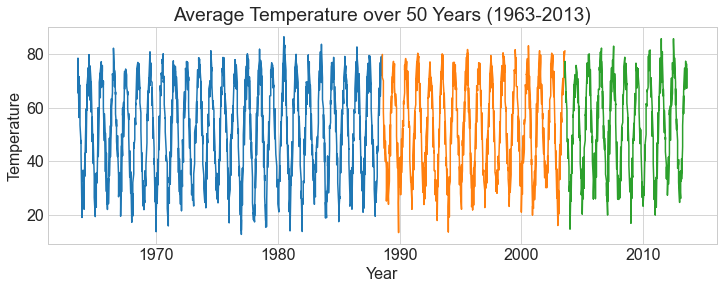

train dataset average temperature: 51.91754339622641


In [11]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel('Temperature')
    plt.xlabel('Year')
    plt.title('Average Temperature over 50 Years (1963-2013)')
    plt.show()
    print('train dataset average temperature:', train.avg_temp.mean())

## Explore

<AxesSubplot:ylabel='Frequency'>

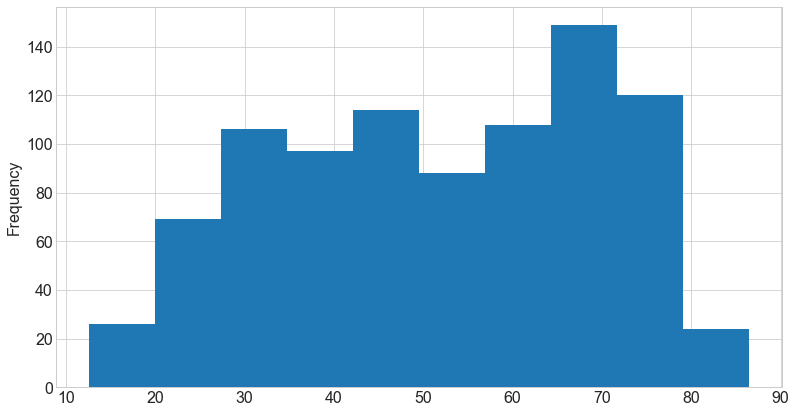

In [12]:
y = train.avg_temp
y.plot.hist()

##### Key Takeaway
- Springfield has a cooler surface temperature overall.

[Text(0.5, 1.0, 'Average Temperature by Year'),
 Text(0.5, 0, 'Year (train)'),
 Text(0, 0.5, 'Temp (F)')]

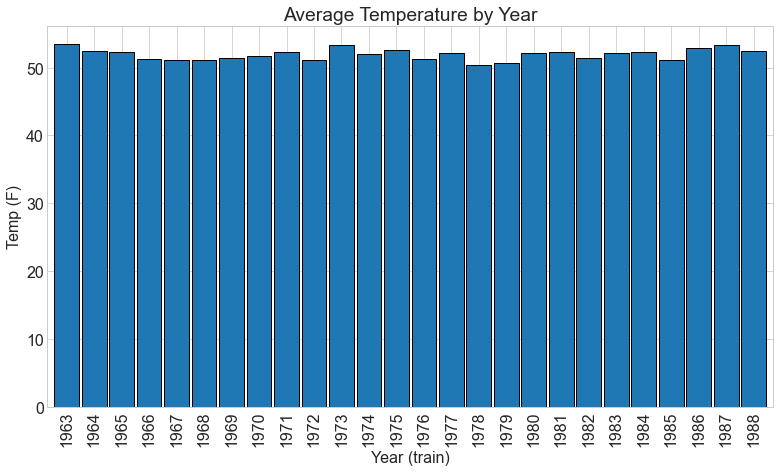

In [13]:
ax = y.groupby(y.index.year).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=90)
ax.set(title='Average Temperature by Year', xlabel='Year (train)', ylabel='Temp (F)')

##### Key Takeaway
- Average temperature over the years seems to be pretty steady.

[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month (train)'),
 Text(0, 0.5, 'Temp (F)')]

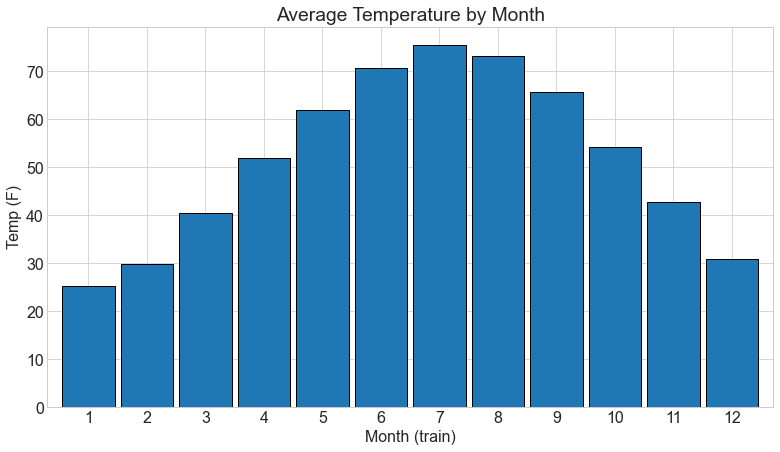

In [14]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month (train)', ylabel='Temp (F)')

##### Key Takeaway
- Warmest month of the year(s) - July
- Plot verifies initital histogram; Springfield has a cooler surface temperature through out the year(s).

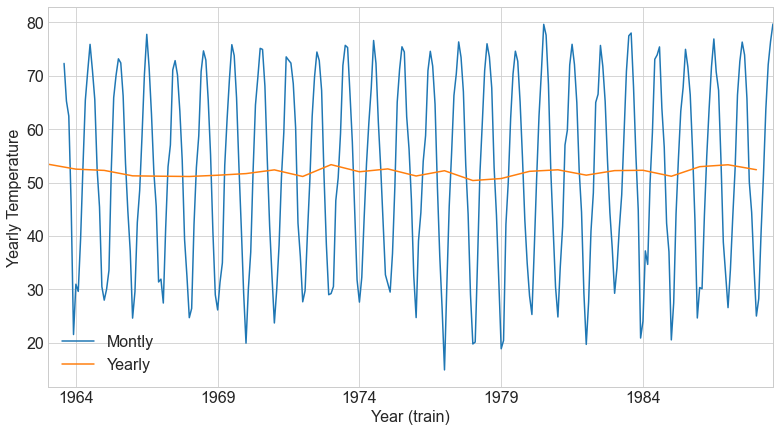

In [15]:
y.resample('M').mean().plot( label='Montly')
y.resample('Y').mean().plot(xlabel = 'Year (train)', ylabel = "Yearly Temperature", label='Yearly')
plt.legend()

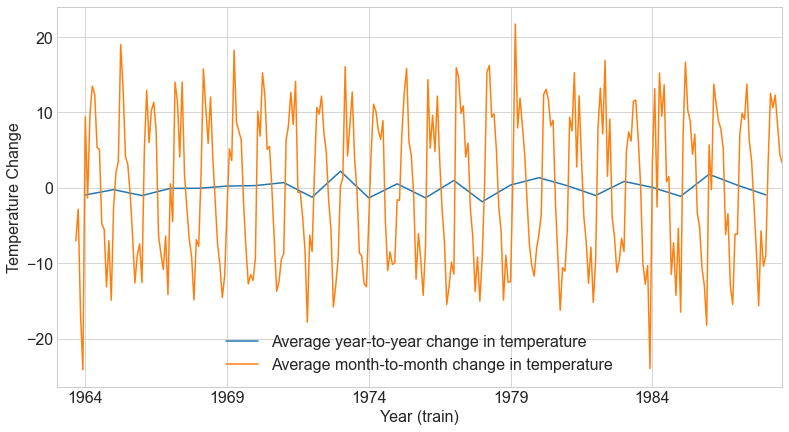

In [16]:
y.resample('Y').mean().diff().plot(label='Average year-to-year change in temperature')
y.resample('M').mean().diff().plot(xlabel = 'Year (train)', ylabel = 'Temperature Change', label='Average month-to-month change in temperature')
plt.legend()

##### Key Takeaways
- Top plot validates steady average temperature by year.
- Bottom plot shows variation in changing temperatures beginning in the mid 1970's through 1998.

Text(0.5, 1.0, 'Lag plot with lag=1')

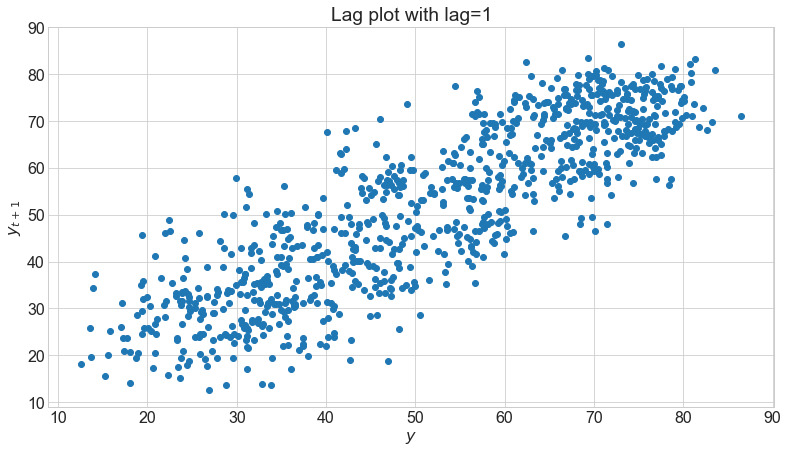

In [17]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

[Text(0.5, 0, 't'), Text(0, 0.5, 't + 1')]

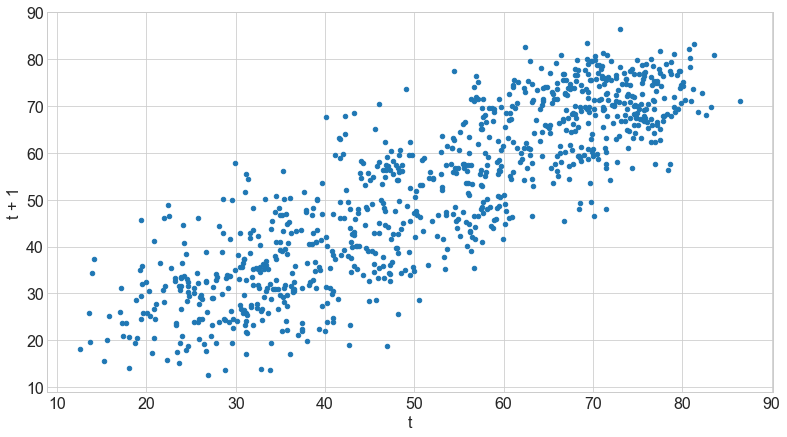

In [18]:
train['y(t + 1)'] = train.avg_temp.shift(-1)
ax = train.plot.scatter(x='avg_temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')

In [19]:
del train['y(t + 1)']

##### Key Takeaway
- Lag plot shows a linear correlation.
- Deleted lag so that it does not distort the remaining analysis.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

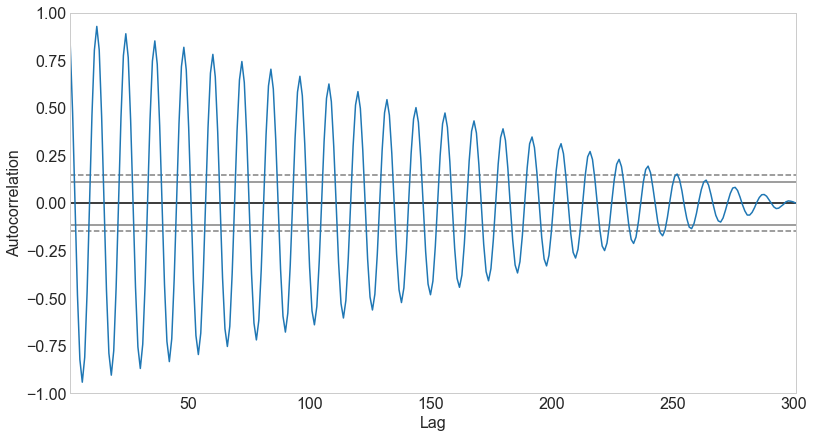

In [20]:
pd.plotting.autocorrelation_plot(train.avg_temp.resample('M').mean())

##### Key Takeaways
- Frequency peaks in which the seasonality repeats itself.
- The valleys show where the correlation is the most negative.

In [21]:
y = train.avg_temp.resample('M').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
date,,,,
1963-08-31,72.28,NaN,21.32,NaN
1963-09-30,65.25,NaN,13.87,NaN
1963-10-31,62.43,NaN,2.04,NaN
1963-11-30,45.70,NaN,-9.13,NaN
1963-12-31,21.55,NaN,-20.47,NaN


<AxesSubplot:xlabel='Year', ylabel='Temperature'>

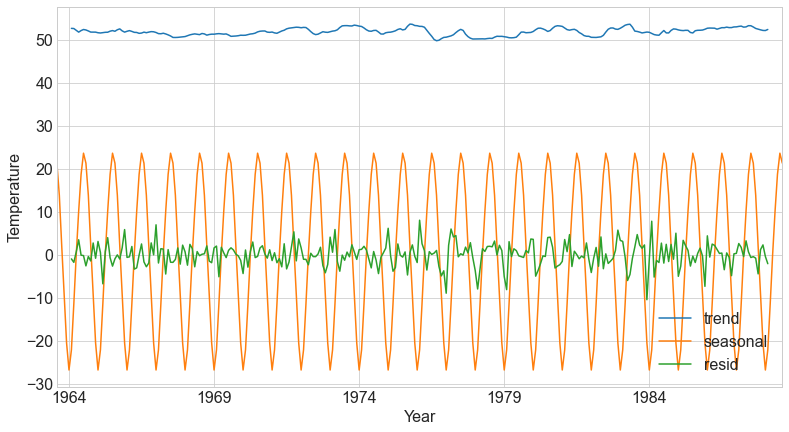

In [22]:
decomposition.iloc[:, 1:].plot(xlabel='Year', ylabel = 'Temperature')

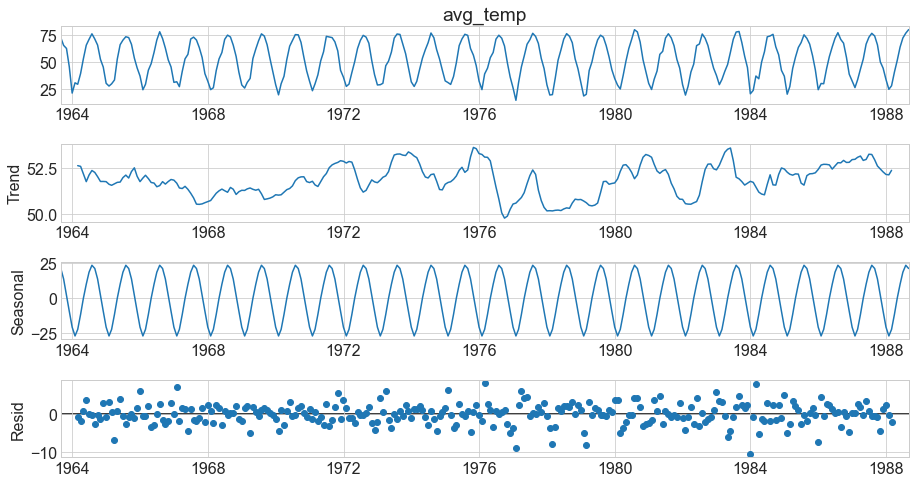

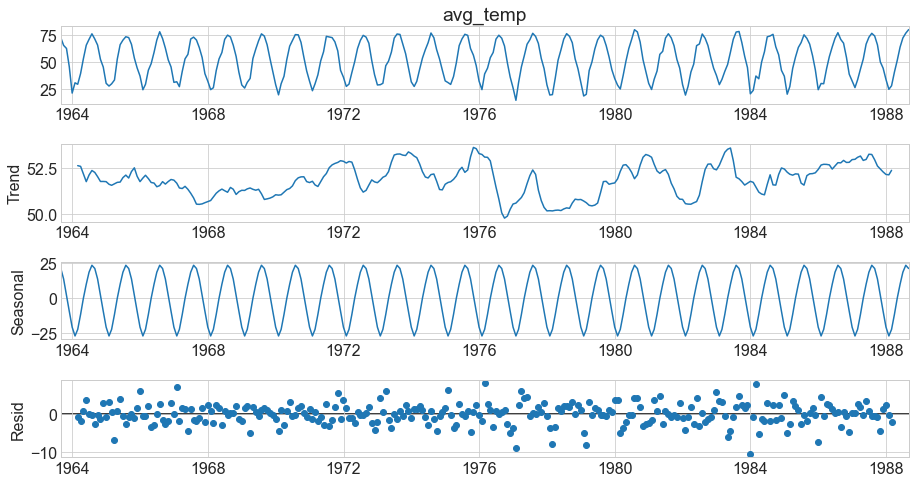

In [23]:
result.plot()

##### Key Takeaways
- A summary of the above exploration validated through composition.

In [24]:
train = train.resample('M').mean()
# create a categorical feature
train['avgtemp_bin'] = pd.qcut(train.avg_temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('avgtemp_bin').mean()

,avg_temp
avgtemp_bin,
cold,28.63
cool,45.17
warm,61.13
hot,73.29


In [25]:
#Remove the avgtemp_bin not to distort modeling
del train['avgtemp_bin']

In [26]:
#Resampled validate dataset to match train resample for modeling
#(Error displayed in Holt's model that led to this correction)
validate = validate.resample('M').mean()

## Model
- Setup functions for modeling.

In [27]:
#evaluation function to compute rmse.
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [28]:
#plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [29]:
#create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

#function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [30]:
eval_df

,model_type,target_var,rmse


### Forecast
- Forcast train and validate datasets on the following models.
- Test on best forecast model.

#### Last observed value

In [31]:
avgtemp = train['avg_temp'][-1:][0]

yhat_df = pd.DataFrame({'avg_temp': [avgtemp]}, index = validate.index)

yhat_df.head(2)

,avg_temp
date,
1988-08-31,79.66
1988-09-30,79.66


avg_temp -- RMSE: 32


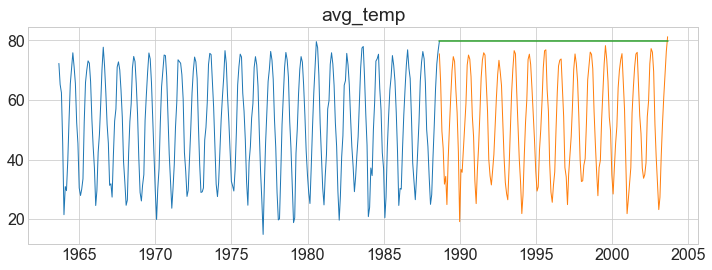

In [32]:
#Plot Actual vs. Predicted Values
for col in train.columns:
    plot_and_eval(col)

In [33]:
#Evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Last Observed Value', target_var = col)

In [34]:
eval_df

,model_type,target_var,rmse
0,Last Observed Value,avg_temp,32.00


#### Simple Average

In [35]:
#Make predictions
avgtemp = round(train['avg_temp'].mean(),2)

def make_predictions():
    yhat_df = pd.DataFrame({'avg_temp': [avgtemp]}, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [36]:
yhat_df.head(2)

,avg_temp
date,
1988-08-31,51.98
1988-09-30,51.98


avg_temp -- RMSE: 17


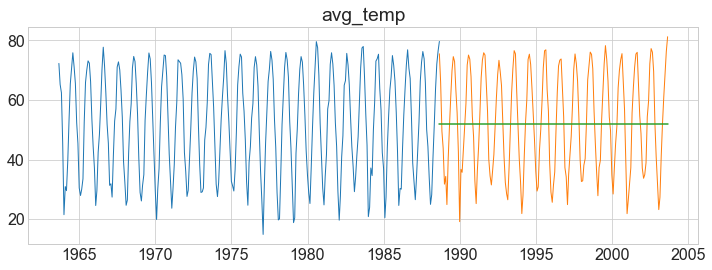

In [37]:
#Plot Actual vs. Predicted Values
for col in train.columns:
    plot_and_eval(col)

In [38]:
#Evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Simple Average', target_var = col)

In [39]:
eval_df

,model_type,target_var,rmse
0,Last Observed Value,avg_temp,32.00
1,Simple Average,avg_temp,17.00


#### Moving Average

In [40]:
#Make Predictions
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 3

avgtemp = round(train['avg_temp'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,avg_temp
date,
1988-08-31,76.04
1988-09-30,76.04
1988-10-31,76.04


avg_temp -- RMSE: 29


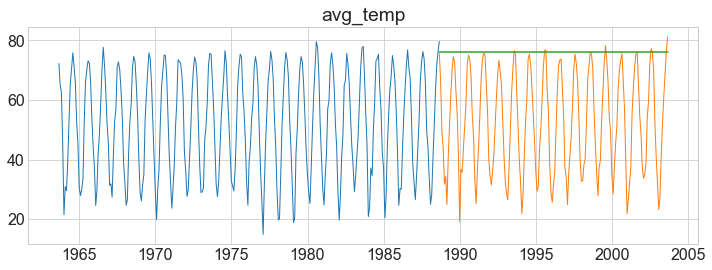

In [41]:
#Plot Actual vs. Predicted Values
for col in train.columns:
    plot_and_eval(col)

In [42]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Moving Average', target_var = col)

In [43]:
eval_df

,model_type,target_var,rmse
0,Last Observed Value,avg_temp,32.00
1,Simple Average,avg_temp,17.00
2,Moving Average,avg_temp,29.00


#### Holt's Linear Trend

avg_temp 



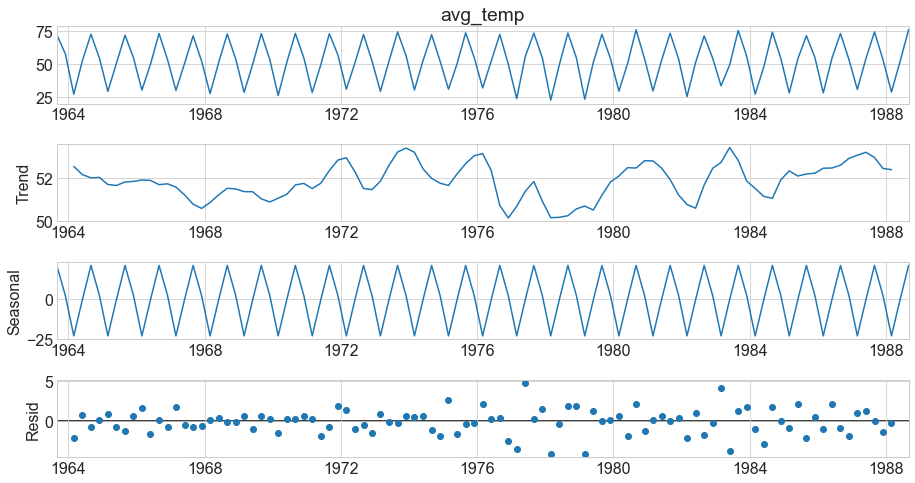

In [44]:
#look at the seasonal decomposition for each target
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
    plt.show()

In [45]:
#Make Predictions
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

avg_temp -- RMSE: 50


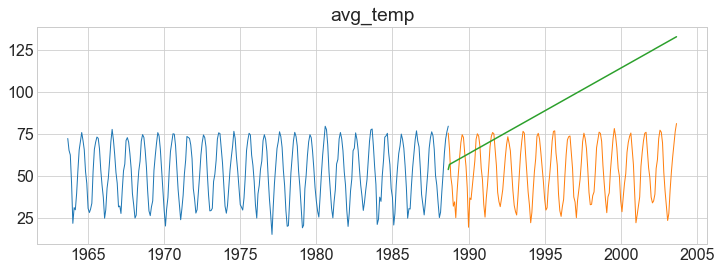

In [46]:
#Plot Actual vs. Predicted Values
for col in train.columns:
    plot_and_eval(target_var = col)

In [47]:
#Evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [48]:
eval_df

,model_type,target_var,rmse
0,Last Observed Value,avg_temp,32.00
1,Simple Average,avg_temp,17.00
2,Moving Average,avg_temp,29.00
3,Holts,avg_temp,50.00


#### Previous Cycle

In [49]:
#Re-split data
train = df['2008':'2010']
validate = df['2011']
test = df['2012']

In [50]:
#Make Predictions
yhat_df = train['2008'] + train.diff(36).mean()

In [51]:
pd.concat([yhat_df.head(1), validate.head(1)])

,avg_temp
date,
2008-01-01,30.87
2011-01-01,19.81


avg_temp -- RMSE: 6


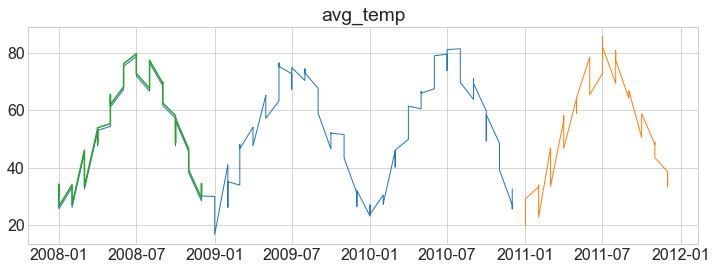

In [52]:
#Plot and Evaluate
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'Previous Cycle', target_var = col)

In [53]:
eval_df

,model_type,target_var,rmse
0,Last Observed Value,avg_temp,32.00
1,Simple Average,avg_temp,17.00
2,Moving Average,avg_temp,29.00
3,Holts,avg_temp,50.00
4,Previous Cycle,avg_temp,6.00


### Best Model

Which model did the best? Then test to that model.

In [54]:
#get the min rmse for the target variable
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[0]

#filter only the rows that match those rmse to find out 
eval_df[(eval_df.rmse == min_rmse_items_sold)]

,model_type,target_var,rmse
4,Previous Cycle,avg_temp,6.00


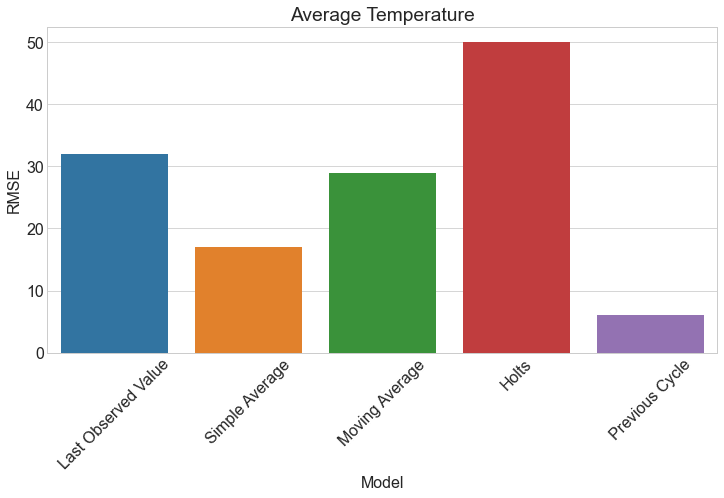

In [55]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title('Average Temperature')
    plt.ylabel('RMSE')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.show()

##### Key Takeaway
- Compared and plotted output RMSE's against each other.
- Previous Cycle model performed much better then the other four.
- Previous Cycle RMSE 6.0.

In [56]:
#Out of sample We will be using train + validate to predict test
yhat_df = validate + train.diff(36).mean()
yhat_df.index = test.index

In [57]:
rmse_avgtemp = round(sqrt(mean_squared_error(test['avg_temp'], yhat_df['avg_temp'])), 0)

In [58]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 5)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title('Average Temperature')
    plt.xlabel('Year')
    plt.ylabel('Temperature')
    plt.show()

rmse - avgtemp:  8.0


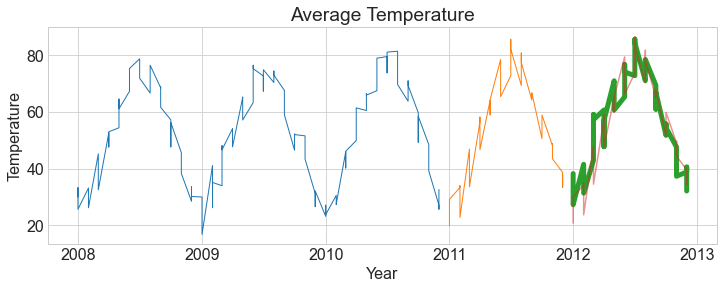

In [59]:
print("rmse - avgtemp: ", rmse_avgtemp)

for col in train.columns:
    plot_and_eval(col)

##### Key Takeaway
- Takes in the trained and out of sample data sets for a comparison.
- Comparison averages seems to be in line with each other.

## Prediction beyond 2013

In [60]:
df = pd.DataFrame({'date': pd.date_range(datetime(2013, 1, 1), datetime(2016, 1, 1), freq='M')}).set_index('date').sort_index()

In [61]:
print('Date Range:', df.index.min(), 'to', df.index.max())

Date Range: 2013-01-31 00:00:00 to 2015-12-31 00:00:00


##### Key Takeaway
- Sets the timeline dataframe for the test dataset to be tested against the Previous Cycle model.
- Predicition is made on a 3 year period.

In [62]:
#Predict on test
yhat_df = test + train.diff(36).mean()
yhat_df = yhat_df.set_index(df.index)
yhat_df.head()

,avg_temp
date,
2013-01-31,39.17
2013-02-28,34.78
2013-03-31,28.17
2013-04-30,42.44
2013-05-31,38.99


##### Key Takeaway
- Adds the test average temperature to the three year prediction dataframe.

In [63]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 5)
    plt.plot(yhat_df[target_var], alpha = .5, linewidth = 5)
    plt.title('Average Temperature (test)')
    plt.xlabel('Year (test)')
    plt.ylabel('Temperature')
    plt.show()

rmse - avgtemp:  8.0


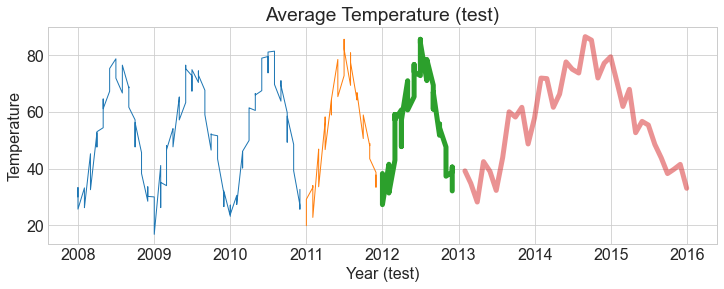

In [64]:
print("rmse - avgtemp: ", rmse_avgtemp)

for col in train.columns:
    plot_and_eval(col)

In [65]:
print('Average, Max and Min temperature recorded:', yhat_df.avg_temp.mean(), yhat_df.avg_temp.max(), 'and', yhat_df.avg_temp.min(), 'respectively')

Average, Max and Min temperature recorded: 57.078375000000015 86.594775 and 28.168575 respectively


##### Key Takeaway
- The prediction shows a consitant increase in surface temperature that is in line with the exploration analysis as well as the train and validate datasets.
- Average temperature shows a steady increase in surface temperature.

## Conclusion

- Analysis of the Springfield, US surface temperature shows a steady increase over the years.
- Modeled test and validate datasets against five different forecast models.
- Previous Cycle performed much better then the other four models.
- Test dataset done on the PRevious Cycle model.
- Test dataset model RMSE 8.0.
- Prediction validate steady increase beyond 2013.
- Three year predicition dataframe is below. Set khat dataframe to_csv to download a copy of the predicted temperatures.